<a href="https://colab.research.google.com/github/putuwaw/weekcon-hands-on/blob/main/image-classification/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
  https://raw.githubusercontent.com/teavanist/MNIST-JPG/refs/heads/master/MNIST%20Dataset%20JPG%20format.zip -O mnist.zip

--2024-10-17 04:05:54--  https://raw.githubusercontent.com/teavanist/MNIST-JPG/refs/heads/master/MNIST%20Dataset%20JPG%20format.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52766564 (50M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  50.32M   220MB/s    in 0.2s    

2024-10-17 04:05:58 (220 MB/s) - ‘mnist.zip’ saved [52766564/52766564]



In [2]:
!unzip -q /content/mnist.zip -d /content/mnist_data

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [4]:
os.rename("/content/mnist_data/MNIST Dataset JPG format", "/content/mnist_data/dataset")

In [5]:
os.rename("/content/mnist_data/dataset/MNIST - JPG - testing", "/content/mnist_data/dataset/testing")

In [6]:
os.rename("/content/mnist_data/dataset/MNIST - JPG - training", "/content/mnist_data/dataset/training")

In [8]:
DATASET_PATH = "/content/mnist_data/dataset"
categories = sorted(os.listdir(f"{DATASET_PATH}/training"))

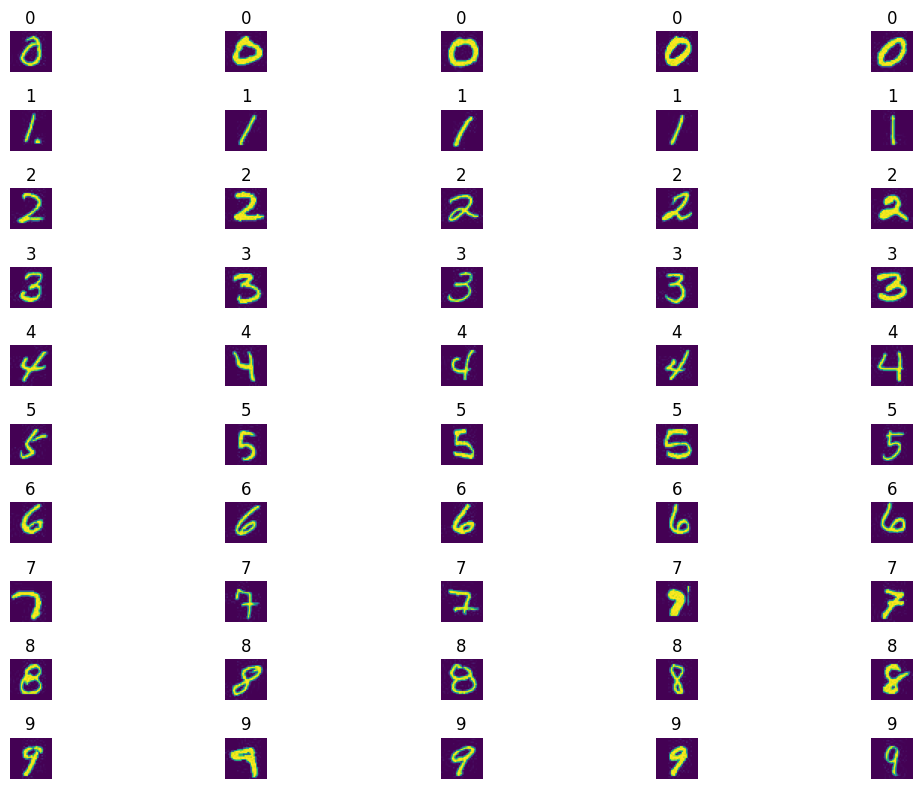

In [9]:
fig, ax = plt.subplots(len(categories), 5, figsize=(12, 8))
for i, category in enumerate(categories):
    category_dir = os.path.join(f"{DATASET_PATH}/training", category)
    image_files = os.listdir(category_dir)

    for j in range(5):
        rdm = random.randint(0, len(image_files))
        img_path = os.path.join(category_dir, image_files[rdm])
        img = mpimg.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].set_title(category)
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    fill_mode='nearest',
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=.1,
    zoom_range=.1,
    validation_split=.4
)

# don't augmented test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)


In [17]:
INPUT_SHAPE = (28, 28, 1) # (28, 28, 3) if rgb
train_dir = f"{DATASET_PATH}/training"
test_dir = f"{DATASET_PATH}/testing"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale', # for mnist, default rgb
    target_size=INPUT_SHAPE[:2],
    class_mode="categorical",
    seed=42,
    batch_size=32,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode='grayscale', # for mnist, default rgb
    target_size=INPUT_SHAPE[:2],
    seed=42,
    batch_size=32,
)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         495,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,146 (1.97 MB)

 Trainable params: 515,146 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

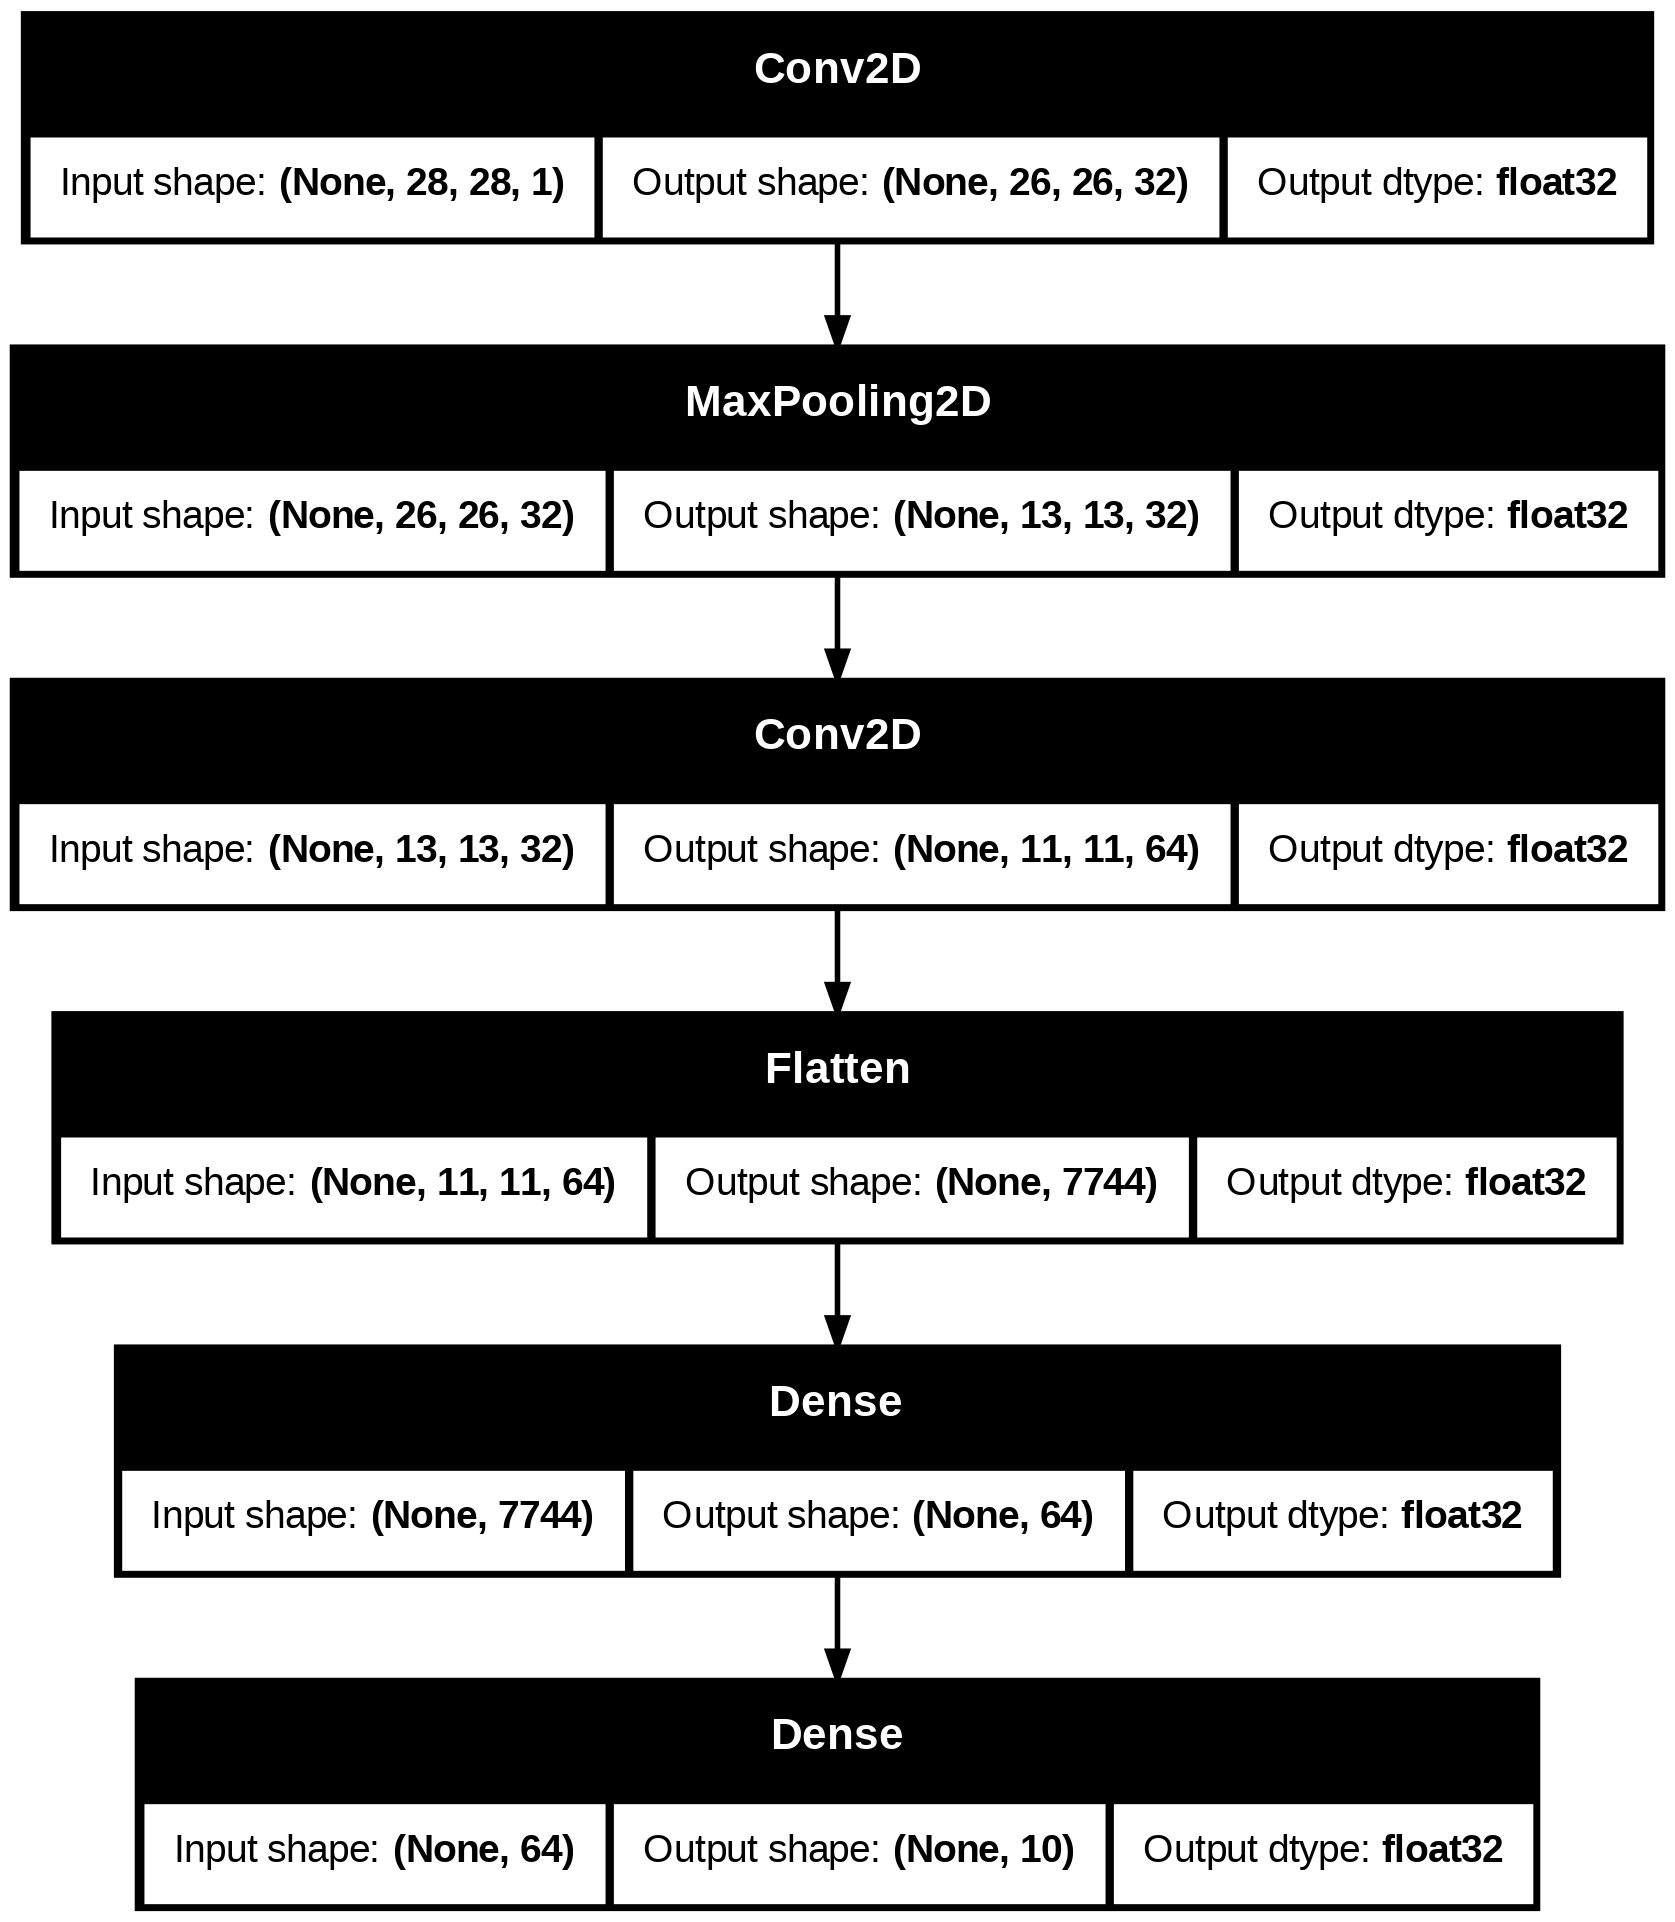

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True,
    show_dtype=True,)

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - accuracy: 0.8437 - loss: 0.4847 - val_accuracy: 0.9861 - val_loss: 0.0412
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - accuracy: 0.9697 - loss: 0.0969 - val_accuracy: 0.9873 - val_loss: 0.0388
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.9772 - loss: 0.0741 - val_accuracy: 0.9895 - val_loss: 0.0337
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9808 - loss: 0.0610 - val_accuracy: 0.9919 - val_loss: 0.0239
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9843 - loss: 0.0491 - val_accuracy: 0.9902 - val_loss: 0.0272


In [24]:
model.save('model.keras')

In [27]:
class_indices = train_generator.class_indices
labels = dict((v, k) for k, v in class_indices.items())

In [33]:
labels

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

Saving 4.png to 4 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted: 4


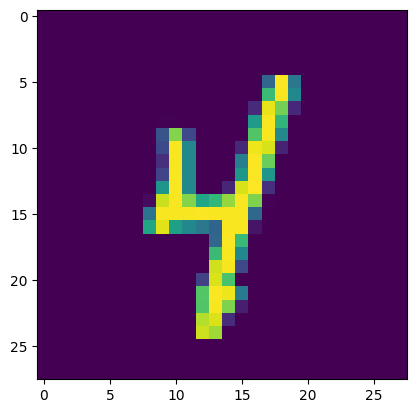

In [32]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = tf.keras.preprocessing.image.load_img(
      path,
      target_size=INPUT_SHAPE[:2],
      color_mode='grayscale', # remove if image is rgb
  )
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  pred = np.argmax(model.predict(images))
  result = labels[pred]
  print(f"Prediction: {result}")